In [1]:
import random
random.seed(42)

In [2]:
NUM_SAMPLES = 100 # number of samples from the dataset to use

In [3]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

  Cloning https://github.com/neelnanda-io/TransformerLens.git to c:\users\reill\appdata\local\temp\pip-req-build-k4j5e78m
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit e65fafb4791c66076bc54ec9731920de1e8c676f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git 'C:\Users\reill\AppData\Local\Temp\pip-req-build-k4j5e78m'

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from transformer_lens import HookedTransformer
import torch
torch.manual_seed(0)
torch.set_grad_enabled(False)  # turn automatic differentiation off to save mem

c:\Users\reill\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
teacher_str = 'gpt2-small'
student_str = 'distillgpt2'

In [6]:
teacher = HookedTransformer.from_pretrained(
    teacher_str,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

student = HookedTransformer.from_pretrained(
    student_str,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

c:\Users\reill\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Loaded pretrained model distillgpt2 into HookedTransformer


In [7]:
from datasets import load_dataset

ds = load_dataset("basicv8vc/SimpleQA", split="test[:10%]")

Generating test split: 100%|██████████| 4326/4326 [00:00<00:00, 98798.05 examples/s]


In [8]:
train_data = ds

corr_sample = []
incorr_sample = []

for i in range(train_data.num_rows):
    if i < 300:
        corr_sample.append(train_data[i])
    else:
        incorr_sample.append(train_data[i])

In [9]:
#selected_data = corr_sample.shuffle(seed=42).select(range(100))
selected_data = random.sample(corr_sample, NUM_SAMPLES)
selected_data[0]

{'metadata': "{'topic': 'Geography', 'answer_type': 'Date', 'urls': ['https://en.wikipedia.org/wiki/Dolmar-Salzbr%C3%BCcke', 'https://en.wikipedia.org/wiki/Dolmar-Salzbr%C3%BCcke', 'https://www.vg-dolmar-salzbruecke.de/verzeichnis/visitenkarte.php?mandat=70081', 'https://de.wikipedia.org/wiki/Verwaltungsgemeinschaft_Dolmar-Salzbr%C3%BCcke']}",
 'problem': 'On which day, month, and year was Dolmar-Salzbrücke formed as a Verwaltungsgemeinschaft?',
 'answer': '1 January 2012 '}

In [10]:
prompts_list = []
prompts_list_2 = []
for i in range(len(selected_data)):
    curr_entry = {}
    curr_entry['text'] = selected_data[i]['problem']
    curr_entry['corr'] = selected_data[i]['answer']
    curr_entry['incorr'] = random.sample(incorr_sample, 1)[0]['answer']
    prompts_list.append(curr_entry)

    curr_entry_2 = {}
    curr_entry_2['text'] = selected_data[i]['problem']
    curr_entry_2['corr'] = random.sample(incorr_sample, 1)[0]['answer']
    curr_entry_2['incorr'] = selected_data[i]['answer']
    prompts_list_2.append(curr_entry_2)

In [11]:
prompts_list[:3]

[{'text': 'On which day, month, and year was Dolmar-Salzbrücke formed as a Verwaltungsgemeinschaft?',
  'corr': '1 January 2012 ',
  'incorr': 'March 2011'},
 {'text': 'The "Un\'alma innamorata" was written by what composer in 1707?',
  'corr': 'George Frideric Handel',
  'incorr': 'Frank Harold Spedding'},
 {'text': 'What did Daemon Targaryen say to Rhaenyra about living life in fear in Episode 4, Season 1 of House of the Dragon?',
  'corr': 'You cannot live your life in fear, or you will forsake the best parts of it.',
  'incorr': '1982'}]

In [12]:
prompts = [a['text'] for a in prompts_list]
len(prompts)

100

In [13]:
tokens_t = teacher.to_tokens(prompts, prepend_bos=True)
tokens_s = student.to_tokens(prompts, prepend_bos=True)
# tokens = tokens.cuda() # Move the tokens to the GPU

original_logits_t, local_cache_t = teacher.run_with_cache(tokens_t)
original_logits_s, local_cache_s = student.run_with_cache(tokens_s)

In [ ]:
import torch
import numpy as np

class TriviaDataset:
    def __init__(self, prompts, tokenizer, max_length=None):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)

        if max_length is None:
            self.max_length = max(len(self.tokenizer(prompt["text"]).input_ids) for prompt in self.prompts)
        else:
            self.max_length = max_length

        tokenized_texts = self.tokenizer(
            [prompt["text"] for prompt in self.prompts],
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        self.toks = tokenized_texts.input_ids  # preserves compatibility with dataset.toks
        self.attention_masks = tokenized_texts.attention_mask

        self.corr_tokenIDs = torch.tensor([
            self.tokenizer.encode(prompt["corr"], add_special_tokens=False)[0]
            for prompt in self.prompts
        ])

        self.incorr_tokenIDs = torch.tensor([
            self.tokenizer.encode(prompt["incorr"], add_special_tokens=False)[0]
            for prompt in self.prompts
        ])

        self.word_idx = {
            "end": torch.tensor([
                (input_ids != 0).sum().item() - 1
                for input_ids in self.toks
            ])
        }

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return {
            "input_ids": self.toks[idx],
            "attention_mask": self.attention_masks[idx],
            "corr_token": self.corr_tokenIDs[idx],
            "incorr_token": self.incorr_tokenIDs[idx],
        }


In [15]:
dataset = TriviaDataset(prompts_list, teacher.tokenizer)
dataset_2 = TriviaDataset(prompts_list_2, teacher.tokenizer)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle

import matplotlib.pyplot as plt
import statistics

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

torch.set_grad_enabled(False)

In [ ]:
from typing import List, Union, Optional
import torch
from torch import Tensor

import torch

def get_logit_diff(logits: Float[Tensor, "batch seq d_vocab"], dataset: TriviaDataset, per_prompt=False):
    batch_size = logits.size(0)

    end_positions = dataset.word_idx["end"].to(dtype=torch.long)
    corr_tokenIDs = dataset.corr_tokenIDs.to(dtype=torch.long)
    incorr_tokenIDs = dataset.incorr_tokenIDs.to(dtype=torch.long)

    assert end_positions.shape == (batch_size,)
    assert corr_tokenIDs.shape == (batch_size,)
    assert incorr_tokenIDs.shape == (batch_size,)

    corr_logits = logits[torch.arange(batch_size), end_positions, corr_tokenIDs]
    incorr_logits = logits[torch.arange(batch_size), end_positions, incorr_tokenIDs]

    answer_logit_diff = corr_logits - incorr_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()



def logit_diff_perc(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_logit_diff: float,
    dataset_1: TriviaDataset,
) -> float:
    patched_logit_diff = get_logit_diff(logits, dataset_1)
    return (patched_logit_diff / clean_logit_diff)

In [19]:
teacher.reset_hooks(including_permanent=True)
logits_original_t = teacher(dataset.toks)
logits_original_s = student(dataset.toks)

In [20]:
orig_score_t = get_logit_diff(logits_original_t, dataset)
orig_score_s = get_logit_diff(logits_original_s, dataset)

In [ ]:
print(orig_score_s, orig_score_t) # logit scores of student and teacher models

tensor(-0.1016) tensor(-0.2043)


In [22]:
import gc

del(logits_original_t)
del(logits_original_s)
torch.cuda.empty_cache()
gc.collect()

20

In [ ]:
def direct_ablate_single_head(
    model: HookedTransformer,
    dataset: TriviaDataset,
    layer: int,
    head: int,
    orig_score: float,
    ablation_type="zero",
    print_output: bool = True
) -> float:
    model.reset_hooks(including_permanent=True)

    if ablation_type == "mean":
        _, cache = model.run_with_cache(
            dataset.toks.long(),
            return_type=None,
            names_filter=lambda name: name.endswith("z") and f"blocks.{layer}" in name
        )
        z_mean = cache[utils.get_act_name("z", layer)].mean(dim=0, keepdim=True)

    def hook_fn(z, hook):
        if hook.layer() == layer:
            z_modified = z.clone()
            if ablation_type == "zero":
                z_modified[:, :, head] = 0
            else:
                z_modified[:, :, head] = z_mean.expand_as(z[:, :, head])
            return z_modified
        return z

    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=False)

    ablated_logits = model(dataset.toks)

    new_score = get_logit_diff(ablated_logits, dataset)

    percent_retained = 100 * (new_score / orig_score)

    if print_output:
        impact = 100 - percent_retained
        print(f"Layer {layer}, Head {head}: Impact = {impact:.2f}%, Retained = {percent_retained:.2f}%")

    model.reset_hooks()
    return percent_retained

student_scores = {}
for layer in range(6):
    for head in range(12):
        retained = direct_ablate_single_head(
            student, dataset, layer, head, orig_score_s, ablation_type="zero"
        )
        student_scores[(layer, head)] = retained

teacher_scores = {}
for layer in range(12):
    for head in range(12):
        retained = direct_ablate_single_head(
            teacher, dataset, layer, head, orig_score_t, ablation_type="zero"
        )
        teacher_scores[(layer, head)] = retained



Layer 0, Head 0: Impact = 4.94%, Retained = 95.06%
Layer 0, Head 1: Impact = -1.25%, Retained = 101.25%
Layer 0, Head 2: Impact = 20.81%, Retained = 79.19%
Layer 0, Head 3: Impact = -0.29%, Retained = 100.29%
Layer 0, Head 4: Impact = 8.63%, Retained = 91.37%
Layer 0, Head 5: Impact = 23.12%, Retained = 76.88%
Layer 0, Head 6: Impact = -61.86%, Retained = 161.86%
Layer 0, Head 7: Impact = -57.23%, Retained = 157.23%
Layer 0, Head 8: Impact = 4.91%, Retained = 95.09%
Layer 0, Head 9: Impact = -22.57%, Retained = 122.57%
Layer 0, Head 10: Impact = 5.92%, Retained = 94.08%
Layer 0, Head 11: Impact = 10.62%, Retained = 89.38%
Layer 1, Head 0: Impact = -0.35%, Retained = 100.35%
Layer 1, Head 1: Impact = -12.77%, Retained = 112.77%
Layer 1, Head 2: Impact = 2.22%, Retained = 97.78%
Layer 1, Head 3: Impact = 2.99%, Retained = 97.01%
Layer 1, Head 4: Impact = 7.90%, Retained = 92.10%
Layer 1, Head 5: Impact = -8.51%, Retained = 108.51%
Layer 1, Head 6: Impact = -1.85%, Retained = 101.85%
Laye

In [24]:
lh_scores_t = teacher_scores
lh_scores_s = student_scores

sorted_lh_scores_t = sorted(lh_scores_t.items(), key=lambda item: -item[1], reverse=True)
modified_scores_t = []

sorted_lh_scores_s = sorted(lh_scores_s.items(), key=lambda item: -item[1], reverse=True)
modified_scores_s = []

for lh, score in sorted_lh_scores_t:
    modified_score = -round(100 - score.item(), 2)
    modified_scores_t.append((lh, modified_score))
scores_attn_t = modified_scores_t

for lh, score in sorted_lh_scores_s:
    modified_score = -round(100 - score.item(), 2)
    modified_scores_s.append((lh, modified_score))
scores_attn_s = modified_scores_s

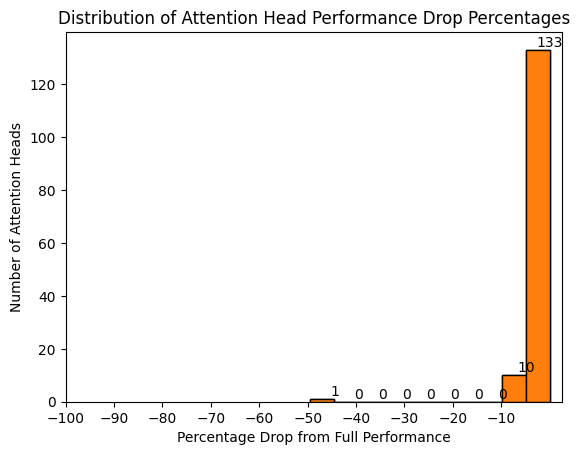

In [ ]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores_t.items()}
scores = list(lh_scores_drop.values())
scores = [s.cpu().numpy() if isinstance(s, torch.Tensor) else s for s in scores]
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')

for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
plt.title('Distribution of Attention Head Performance Drop Percentages')

plt.show()

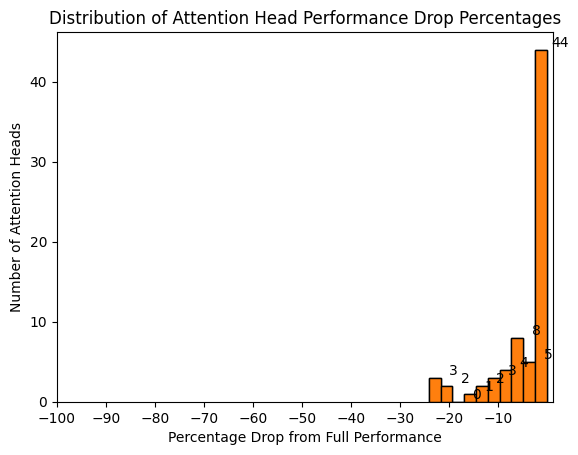

In [26]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores_s.items()}
scores = list(lh_scores_drop.values())
scores = [s.cpu().numpy() if isinstance(s, torch.Tensor) else s for s in scores]
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')

for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
plt.title('Distribution of Attention Head Performance Drop Percentages')

plt.show()

In [ ]:
def direct_ablate_single_mlp(
    model: HookedTransformer,
    dataset: TriviaDataset,
    layer: int,
    orig_score: float,
    ablation_type="zero",
    print_output: bool = True
) -> float:
    model.reset_hooks(including_permanent=True)

    if ablation_type == "mean":
        _, cache = model.run_with_cache(
            dataset.toks.long(),
            return_type=None,
            names_filter=lambda name: name.endswith("mlp_out") and f"blocks.{layer}" in name
        )
        mlp_mean = cache[utils.get_act_name("mlp_out", layer)].mean(dim=0, keepdim=True)

    def hook_fn(mlp_out, hook):
        if hook.layer() == layer:
            if ablation_type == "zero":
                return torch.zeros_like(mlp_out)
            else:
                return mlp_mean.expand_as(mlp_out)
        return mlp_out

    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=False)

    ablated_logits = model(dataset.toks)

    new_score = get_logit_diff(ablated_logits, dataset)

    percent_retained = 100 * (new_score / orig_score)

    if print_output:
        impact = 100 - percent_retained
        print(f"Layer {layer} MLP: Impact = {impact:.2f}%, Retained = {percent_retained:.2f}%")

    model.reset_hooks()
    return percent_retained


scores_mlp_t = []
scores_mlp_s = []

print("Analyzing teacher model MLPs...")
for layer in range(12):
    retained = max(0, direct_ablate_single_mlp(teacher, dataset, layer, orig_score_t, ablation_type="zero", print_output=False))
    try:
      scores_mlp_t.append((layer, -round(100 - retained.item(), 2)))
    except:
      scores_mlp_t.append((layer, -round(100 - retained, 2)))
    print(f"Completed Layer {layer} MLP: Retained = {retained:.2f}%")

print("\nAnalyzing student model MLPs...")
for layer in range(6):
    retained = max(0, direct_ablate_single_mlp(student, dataset, layer, orig_score_s, ablation_type="zero", print_output=False))
    try:
      scores_mlp_s.append((layer, -round(100 - retained.item(), 2)))
    except:
      scores_mlp_s.append((layer, -round(100 - retained, 2)))
    print(f"Completed Layer {layer} MLP: Retained = {retained:.2f}%")


Analyzing teacher model MLPs...
Completed Layer 0 MLP: Retained = 69.71%
Completed Layer 1 MLP: Retained = 80.00%
Completed Layer 2 MLP: Retained = 96.66%
Completed Layer 3 MLP: Retained = 99.93%
Completed Layer 4 MLP: Retained = 89.81%
Completed Layer 5 MLP: Retained = 96.02%
Completed Layer 6 MLP: Retained = 98.66%
Completed Layer 7 MLP: Retained = 116.48%
Completed Layer 8 MLP: Retained = 103.10%
Completed Layer 9 MLP: Retained = 96.27%
Completed Layer 10 MLP: Retained = 91.79%
Completed Layer 11 MLP: Retained = 41.57%

Analyzing student model MLPs...
Completed Layer 0 MLP: Retained = 590.56%
Completed Layer 1 MLP: Retained = 114.55%
Completed Layer 2 MLP: Retained = 100.13%
Completed Layer 3 MLP: Retained = 121.69%
Completed Layer 4 MLP: Retained = 107.33%
Completed Layer 5 MLP: Retained = 78.21%


In [ ]:
scores_combined_t = scores_mlp_t + scores_attn_t
scores_combined_s = scores_mlp_s + scores_attn_s

In [ ]:
import torch
import torch.nn.functional as F

sims = {}
max_vals_attn = {}

for student_layer in range(6):
    for student_head in range(12):
        curr_comb = (student_layer, student_head)
        if curr_comb not in max_vals_attn.keys():
            max_vals_attn[curr_comb] = (None, 0)
        for teacher_layer in range(12):
            for teacher_head in range(12):
                curr_s = local_cache_s["attn", student_layer][:, student_head].mean(dim=0)
                curr_t = local_cache_t["attn", teacher_layer][:, teacher_head].mean(dim=0)
                sim = torch.mean(F.cosine_similarity(curr_s.unsqueeze(1), curr_t.unsqueeze(1), dim=2))
                if sim >= max_vals_attn[curr_comb][1]:
                    max_vals_attn[curr_comb] = ((teacher_layer, teacher_head), sim)
                sims[(student_layer, student_head, teacher_layer, teacher_head)] = sim
student_layer = 4
student_head = 11
teacher_layer = 9
teacher_head = 11

print(f"Similarity between TL{teacher_layer}H{teacher_head}/SL{student_layer}H{student_head}: {sims[(student_layer, student_head, teacher_layer, teacher_head)]}")

mean_val = torch.mean(torch.stack(list(sims.values())))
print(f"Mean similarity across all heads: {mean_val}")


Similarity between TL9H11/SL4H11: 0.9400879144668579
Mean similarity across all heads: 0.7091394662857056


In [31]:
max_vals_attn

{(0, 0): ((0, 0), tensor(0.9692)),
 (0, 1): ((0, 5), tensor(0.9868)),
 (0, 2): ((0, 11), tensor(0.9836)),
 (0, 3): ((0, 3), tensor(0.9904)),
 (0, 4): ((0, 4), tensor(0.9802)),
 (0, 5): ((0, 5), tensor(0.9926)),
 (0, 6): ((0, 6), tensor(0.9765)),
 (0, 7): ((1, 0), tensor(0.9822)),
 (0, 8): ((0, 11), tensor(0.9816)),
 (0, 9): ((1, 9), tensor(0.9624)),
 (0, 10): ((0, 2), tensor(0.9630)),
 (0, 11): ((1, 8), tensor(0.8901)),
 (1, 0): ((2, 0), tensor(0.9779)),
 (1, 1): ((8, 0), tensor(0.9819)),
 (1, 2): ((1, 0), tensor(0.9485)),
 (1, 3): ((1, 0), tensor(0.9905)),
 (1, 4): ((9, 3), tensor(0.9703)),
 (1, 5): ((1, 1), tensor(0.9732)),
 (1, 6): ((1, 6), tensor(0.9890)),
 (1, 7): ((11, 4), tensor(0.9933)),
 (1, 8): ((1, 0), tensor(0.9770)),
 (1, 9): ((1, 0), tensor(0.9786)),
 (1, 10): ((1, 6), tensor(0.9934)),
 (1, 11): ((4, 4), tensor(0.9989)),
 (2, 0): ((4, 0), tensor(0.9727)),
 (2, 1): ((9, 3), tensor(0.9498)),
 (2, 2): ((8, 0), tensor(0.9880)),
 (2, 3): ((4, 0), tensor(0.9511)),
 (2, 4): ((8,

In [ ]:
import numpy as np
from scipy.linalg import svd
from sklearn.metrics.pairwise import cosine_similarity

def activation_eigenvector_similarity(layer1, layer2, k=3):
    acts1 = np.array(local_cache_t[f'blocks.{layer1}.hook_mlp_out'].cpu())
    acts2 = np.array(local_cache_s[f'blocks.{layer2}.hook_mlp_out'].cpu())

    acts1_flattened = acts1.reshape(-1, acts1.shape[-1])
    acts2_flattened = acts2.reshape(-1, acts2.shape[-1])

    cov1 = np.dot(acts1_flattened.T, acts1_flattened) / acts1_flattened.shape[0] # covariance matrices
    cov2 = np.dot(acts2_flattened.T, acts2_flattened) / acts2_flattened.shape[0]

    # get eigenvectors with singular value decomp
    U1, _, _ = svd(cov1)
    U2, _, _ = svd(cov2)
    U1_topk = U1[:, :k]
    U2_topk = U2[:, :k]

    similarity_matrix = cosine_similarity(U1_topk.T, U2_topk.T)
    avg_similarity = np.mean(similarity_matrix)

    return avg_similarity

In [ ]:
sims_mlp = {}

for i in range(0, 6):
    for j in range(0, 12):
        curr_sim = abs(activation_eigenvector_similarity(j, i))
        sims_mlp[(i, j)] = curr_sim

In [34]:
import torch
import numpy as np

mlp_keys = [k for k, v in sims_mlp.items() if v > 0]
mlp_values = np.array([v for v in sims_mlp.values() if v > 0])

attn_values = torch.tensor([v.item() for v in sims.values()])

mlp_mean, mlp_std = np.mean(mlp_values), np.std(mlp_values)
attn_mean, attn_std = torch.mean(attn_values), torch.std(attn_values)

if mlp_values.size > 0:
    mlp_min, mlp_max = np.min(mlp_values), np.max(mlp_values)
else:
    mlp_min, mlp_max = 0, 0
if attn_values.numel() > 0:
    attn_min, attn_max = torch.min(attn_values), torch.max(attn_values)
else:
    attn_min, attn_max = 0, 0

mlp_values_normalized = ((mlp_values - mlp_mean) / mlp_std) * attn_std.item() + attn_mean.item()

mlp_adjusted_values = mlp_values_normalized

sims_mlp_adjusted = {k: v for k, v in zip(mlp_keys, mlp_adjusted_values)}

sims_mlp_adjusted.update({k: 0 for k in sims_mlp if k not in sims_mlp_adjusted})

max_val = max(sims_mlp_adjusted.values())

if max_val == 0:
    sim_mlp_scaled = {key: 0 for key in sims_mlp_adjusted.keys()}
else:
    sim_mlp_scaled = {key: val / max_val for key, val in sims_mlp_adjusted.items()}




In [35]:
sims_mlp = sim_mlp_scaled

In [36]:
sims_mlp

{(0, 0): 0.31188947,
 (0, 1): 0.520239,
 (0, 2): 0.25778723,
 (0, 3): 0.32660085,
 (0, 4): 0.34923178,
 (0, 5): 0.2712322,
 (0, 6): 0.22443229,
 (0, 7): 0.35297254,
 (0, 8): 0.20614006,
 (0, 9): 0.23280938,
 (0, 10): 0.26221025,
 (0, 11): 0.42868578,
 (1, 0): 0.28632304,
 (1, 1): 0.20374303,
 (1, 2): 0.6097447,
 (1, 3): 0.29399192,
 (1, 4): 0.45151642,
 (1, 5): 0.5072657,
 (1, 6): 0.74414206,
 (1, 7): 0.2892293,
 (1, 8): 0.6157124,
 (1, 9): 0.5684113,
 (1, 10): 0.47857526,
 (1, 11): 0.5608996,
 (2, 0): 0.8750816,
 (2, 1): 0.8326812,
 (2, 2): 0.57632947,
 (2, 3): 0.7622476,
 (2, 4): 0.60215414,
 (2, 5): 0.5514144,
 (2, 6): 0.74919593,
 (2, 7): 0.23603144,
 (2, 8): 0.5768035,
 (2, 9): 0.43189055,
 (2, 10): 0.5565014,
 (2, 11): 0.63715625,
 (3, 0): 0.5206203,
 (3, 1): 0.5777837,
 (3, 2): 0.71421546,
 (3, 3): 0.645264,
 (3, 4): 0.65706354,
 (3, 5): 0.62145275,
 (3, 6): 1.0,
 (3, 7): 0.35748395,
 (3, 8): 0.83950955,
 (3, 9): 0.67868245,
 (3, 10): 0.5841515,
 (3, 11): 0.21057874,
 (4, 0): 0.

In [37]:
max_vals_mlp = {}

for (i, j), val in sims_mlp.items():
    if i not in max_vals_mlp or val > max_vals_mlp[i][1]:
        max_vals_mlp[i] = (j, val)

max_vals_mlp

{0: (1, 0.520239),
 1: (6, 0.74414206),
 2: (0, 0.8750816),
 3: (6, 1.0),
 4: (7, 0.67505574),
 5: (9, 0.61119694)}

In [ ]:
component_influence_teacher = scores_combined_t
component_influence_student = scores_combined_s

In [39]:
attn_matches = max_vals_attn
mlp_matches = max_vals_mlp
print(sorted(attn_matches.items(), key=lambda x: x[1][1], reverse=True))
print(sorted(mlp_matches.items(), key=lambda x: x[1][1], reverse=True))

[((1, 11), ((4, 4), tensor(0.9989))), ((5, 11), ((8, 2), tensor(0.9981))), ((4, 7), ((8, 3), tensor(0.9975))), ((5, 6), ((10, 2), tensor(0.9971))), ((5, 2), ((8, 3), tensor(0.9967))), ((5, 3), ((10, 4), tensor(0.9967))), ((5, 5), ((10, 2), tensor(0.9966))), ((5, 9), ((11, 7), tensor(0.9950))), ((5, 10), ((10, 4), tensor(0.9941))), ((5, 1), ((4, 4), tensor(0.9939))), ((4, 9), ((11, 7), tensor(0.9939))), ((1, 10), ((1, 6), tensor(0.9934))), ((1, 7), ((11, 4), tensor(0.9933))), ((5, 7), ((4, 4), tensor(0.9931))), ((4, 10), ((4, 4), tensor(0.9931))), ((0, 5), ((0, 5), tensor(0.9926))), ((3, 9), ((11, 3), tensor(0.9924))), ((4, 6), ((10, 8), tensor(0.9918))), ((3, 4), ((10, 4), tensor(0.9918))), ((3, 3), ((4, 4), tensor(0.9910))), ((1, 3), ((1, 0), tensor(0.9905))), ((4, 8), ((11, 3), tensor(0.9904))), ((0, 3), ((0, 3), tensor(0.9904))), ((3, 8), ((11, 3), tensor(0.9896))), ((1, 6), ((1, 6), tensor(0.9890))), ((2, 6), ((8, 0), tensor(0.9890))), ((4, 0), ((11, 3), tensor(0.9889))), ((2, 2), 

In [ ]:
teacher_influences = {comp: abs(score) for comp, score in component_influence_teacher}
student_influences = {comp: abs(score) for comp, score in component_influence_student}
teacher_probs, student_probs = teacher_influences, student_influences

In [42]:
attn_sims = []

In [44]:
attn_matches

{(0, 0): ((0, 0), tensor(0.9692)),
 (0, 1): ((0, 5), tensor(0.9868)),
 (0, 2): ((0, 11), tensor(0.9836)),
 (0, 3): ((0, 3), tensor(0.9904)),
 (0, 4): ((0, 4), tensor(0.9802)),
 (0, 5): ((0, 5), tensor(0.9926)),
 (0, 6): ((0, 6), tensor(0.9765)),
 (0, 7): ((1, 0), tensor(0.9822)),
 (0, 8): ((0, 11), tensor(0.9816)),
 (0, 9): ((1, 9), tensor(0.9624)),
 (0, 10): ((0, 2), tensor(0.9630)),
 (0, 11): ((1, 8), tensor(0.8901)),
 (1, 0): ((2, 0), tensor(0.9779)),
 (1, 1): ((8, 0), tensor(0.9819)),
 (1, 2): ((1, 0), tensor(0.9485)),
 (1, 3): ((1, 0), tensor(0.9905)),
 (1, 4): ((9, 3), tensor(0.9703)),
 (1, 5): ((1, 1), tensor(0.9732)),
 (1, 6): ((1, 6), tensor(0.9890)),
 (1, 7): ((11, 4), tensor(0.9933)),
 (1, 8): ((1, 0), tensor(0.9770)),
 (1, 9): ((1, 0), tensor(0.9786)),
 (1, 10): ((1, 6), tensor(0.9934)),
 (1, 11): ((4, 4), tensor(0.9989)),
 (2, 0): ((4, 0), tensor(0.9727)),
 (2, 1): ((9, 3), tensor(0.9498)),
 (2, 2): ((8, 0), tensor(0.9880)),
 (2, 3): ((4, 0), tensor(0.9511)),
 (2, 4): ((8,

In [ ]:
filtered_attn = [match for match in attn_matches.items()]

matched_attn_sim = set(attn_matches.items())
unmatched_attn_sim = set(attn_matches.items()) - set(filtered_attn)

filtered_attn_list = [x[0] for x in filtered_attn]

In [46]:
matched_attn_sim

{((0, 0), ((0, 0), tensor(0.9692))),
 ((0, 1), ((0, 5), tensor(0.9868))),
 ((0, 2), ((0, 11), tensor(0.9836))),
 ((0, 3), ((0, 3), tensor(0.9904))),
 ((0, 4), ((0, 4), tensor(0.9802))),
 ((0, 5), ((0, 5), tensor(0.9926))),
 ((0, 6), ((0, 6), tensor(0.9765))),
 ((0, 7), ((1, 0), tensor(0.9822))),
 ((0, 8), ((0, 11), tensor(0.9816))),
 ((0, 9), ((1, 9), tensor(0.9624))),
 ((0, 10), ((0, 2), tensor(0.9630))),
 ((0, 11), ((1, 8), tensor(0.8901))),
 ((1, 0), ((2, 0), tensor(0.9779))),
 ((1, 1), ((8, 0), tensor(0.9819))),
 ((1, 2), ((1, 0), tensor(0.9485))),
 ((1, 3), ((1, 0), tensor(0.9905))),
 ((1, 4), ((9, 3), tensor(0.9703))),
 ((1, 5), ((1, 1), tensor(0.9732))),
 ((1, 6), ((1, 6), tensor(0.9890))),
 ((1, 7), ((11, 4), tensor(0.9933))),
 ((1, 8), ((1, 0), tensor(0.9770))),
 ((1, 9), ((1, 0), tensor(0.9786))),
 ((1, 10), ((1, 6), tensor(0.9934))),
 ((1, 11), ((4, 4), tensor(0.9989))),
 ((2, 0), ((4, 0), tensor(0.9727))),
 ((2, 1), ((9, 3), tensor(0.9498))),
 ((2, 2), ((8, 0), tensor(0.988

In [47]:
unmatched_attn_sim

{((0, 11), ((1, 8), tensor(0.8901))),
 ((1, 2), ((1, 0), tensor(0.9485))),
 ((2, 1), ((9, 3), tensor(0.9498))),
 ((2, 5), ((9, 3), tensor(0.9489))),
 ((2, 11), ((1, 0), tensor(0.8506))),
 ((5, 0), ((1, 9), tensor(0.9362))),
 ((5, 8), ((11, 8), tensor(0.9221)))}

In [48]:
mlp_matches.items()

dict_items([(0, (1, 0.520239)), (1, (6, 0.74414206)), (2, (0, 0.8750816)), (3, (6, 1.0)), (4, (7, 0.67505574)), (5, (9, 0.61119694))])

In [ ]:
filtered_mlp = [match for match in mlp_matches.items()]

matched_mlp_sim = set(filtered_mlp)
unmatched_mlp_sim = set(mlp_matches.items()) - set(filtered_mlp)

filtered_mlp_list = [a[0] for a in filtered_mlp]
filtered_mlp_list


[0, 1, 2, 3, 4, 5]

In [50]:
matched_mlp_sim

{(0, (1, 0.520239)),
 (1, (6, 0.74414206)),
 (2, (0, 0.8750816)),
 (3, (6, 1.0)),
 (4, (7, 0.67505574)),
 (5, (9, 0.61119694))}

In [51]:
unmatched_mlp_sim

set()

In [52]:
matched = list(matched_attn_sim) + list(matched_mlp_sim)
unmatched = list(unmatched_attn_sim) + list(unmatched_mlp_sim)

In [53]:
matched

[((0, 8), ((0, 11), tensor(0.9816))),
 ((1, 10), ((1, 6), tensor(0.9934))),
 ((1, 1), ((8, 0), tensor(0.9819))),
 ((2, 4), ((8, 0), tensor(0.9880))),
 ((2, 8), ((8, 0), tensor(0.9849))),
 ((2, 0), ((4, 0), tensor(0.9727))),
 ((3, 5), ((11, 3), tensor(0.9841))),
 ((0, 11), ((1, 8), tensor(0.8901))),
 ((1, 4), ((9, 3), tensor(0.9703))),
 ((4, 9), ((11, 7), tensor(0.9939))),
 ((5, 3), ((10, 4), tensor(0.9967))),
 ((4, 8), ((11, 3), tensor(0.9904))),
 ((4, 3), ((9, 3), tensor(0.9578))),
 ((1, 8), ((1, 0), tensor(0.9770))),
 ((1, 7), ((11, 4), tensor(0.9933))),
 ((2, 6), ((8, 0), tensor(0.9890))),
 ((4, 6), ((10, 8), tensor(0.9918))),
 ((0, 10), ((0, 2), tensor(0.9630))),
 ((5, 11), ((8, 2), tensor(0.9981))),
 ((5, 2), ((8, 3), tensor(0.9967))),
 ((2, 9), ((11, 3), tensor(0.9872))),
 ((1, 2), ((1, 0), tensor(0.9485))),
 ((2, 3), ((4, 0), tensor(0.9511))),
 ((2, 7), ((1, 11), tensor(0.9590))),
 ((2, 11), ((1, 0), tensor(0.8506))),
 ((5, 1), ((4, 4), tensor(0.9939))),
 ((1, 11), ((4, 4), tens

In [54]:
unmatched

[((2, 11), ((1, 0), tensor(0.8506))),
 ((1, 2), ((1, 0), tensor(0.9485))),
 ((5, 0), ((1, 9), tensor(0.9362))),
 ((5, 8), ((11, 8), tensor(0.9221))),
 ((2, 1), ((9, 3), tensor(0.9498))),
 ((0, 11), ((1, 8), tensor(0.8901))),
 ((2, 5), ((9, 3), tensor(0.9489)))]

In [ ]:
all_sims = matched + unmatched
matched_norm = [
    (entry[0], (entry[1][0], entry[1][1]))
    for entry in matched
]

unmatched_norm = [
    (entry[0], (entry[1][0], entry[1][1]))
    for entry in unmatched
]

In [56]:
matched_norm

[((0, 8), ((0, 11), tensor(0.9816))),
 ((1, 10), ((1, 6), tensor(0.9934))),
 ((1, 1), ((8, 0), tensor(0.9819))),
 ((2, 4), ((8, 0), tensor(0.9880))),
 ((2, 8), ((8, 0), tensor(0.9849))),
 ((2, 0), ((4, 0), tensor(0.9727))),
 ((3, 5), ((11, 3), tensor(0.9841))),
 ((0, 11), ((1, 8), tensor(0.8901))),
 ((1, 4), ((9, 3), tensor(0.9703))),
 ((4, 9), ((11, 7), tensor(0.9939))),
 ((5, 3), ((10, 4), tensor(0.9967))),
 ((4, 8), ((11, 3), tensor(0.9904))),
 ((4, 3), ((9, 3), tensor(0.9578))),
 ((1, 8), ((1, 0), tensor(0.9770))),
 ((1, 7), ((11, 4), tensor(0.9933))),
 ((2, 6), ((8, 0), tensor(0.9890))),
 ((4, 6), ((10, 8), tensor(0.9918))),
 ((0, 10), ((0, 2), tensor(0.9630))),
 ((5, 11), ((8, 2), tensor(0.9981))),
 ((5, 2), ((8, 3), tensor(0.9967))),
 ((2, 9), ((11, 3), tensor(0.9872))),
 ((1, 2), ((1, 0), tensor(0.9485))),
 ((2, 3), ((4, 0), tensor(0.9511))),
 ((2, 7), ((1, 11), tensor(0.9590))),
 ((2, 11), ((1, 0), tensor(0.8506))),
 ((5, 1), ((4, 4), tensor(0.9939))),
 ((1, 11), ((4, 4), tens

In [57]:
student_matched = []
student_unmatched = []

for student_comp, (teacher_comp, similarity) in matched_norm:
    try:
        student_matched.append((student_probs[student_comp], teacher_probs[teacher_comp], similarity.item()))
    except:
        student_matched.append((student_probs[student_comp], teacher_probs[teacher_comp], similarity))

for student_comp, (teacher_comp, similarity) in unmatched_norm:
    try:
        student_unmatched.append((student_probs[student_comp], teacher_probs[teacher_comp], similarity.item()))
    except:
        student_unmatched.append((student_probs[student_comp], teacher_probs[teacher_comp], similarity))

In [58]:
student_unmatched

[(0.82, 0.75, 0.850647509098053),
 (2.22, 0.75, 0.9484831094741821),
 (3.7, 6.92, 0.9361526370048523),
 (26.64, 2.14, 0.9220694303512573),
 (1.35, 2.73, 0.9498333930969238),
 (10.62, 2.91, 0.8901138305664062),
 (7.98, 2.73, 0.948900580406189)]

In [59]:
student_matched

[(4.91, 52.09, 0.9815571904182434),
 (23.3, 4.85, 0.9933798313140869),
 (12.77, 6.04, 0.9818674921989441),
 (24.14, 6.04, 0.9880269169807434),
 (2.35, 6.04, 0.9848790168762207),
 (3.26, 0.67, 0.972711980342865),
 (5.0, 0.89, 0.9841490387916565),
 (10.62, 2.91, 0.8901138305664062),
 (7.9, 2.73, 0.97028648853302),
 (5.53, 4.48, 0.9938607811927795),
 (0.81, 20.96, 0.996719479560852),
 (5.52, 0.89, 0.9903883934020996),
 (7.12, 2.73, 0.9577918648719788),
 (4.5, 0.75, 0.9769898653030396),
 (7.2, 7.33, 0.9932501912117004),
 (3.88, 6.04, 0.9889573454856873),
 (2.88, 4.93, 0.9918315410614014),
 (5.92, 4.41, 0.9630400538444519),
 (5.02, 0.05, 0.99814373254776),
 (1.57, 9.49, 0.9967337250709534),
 (0.1, 0.89, 0.9872490763664246),
 (2.22, 0.75, 0.9484831094741821),
 (3.95, 0.67, 0.9511080384254456),
 (15.0, 5.08, 0.9590470790863037),
 (0.82, 0.75, 0.850647509098053),
 (4.45, 0.6, 0.9938924312591553),
 (7.93, 0.6, 0.9989297986030579),
 (1.35, 2.73, 0.9498333930969238),
 (2.98, 0.89, 0.9585316777229

In [60]:
all_student = student_unmatched + student_matched

In [61]:
all_student

[(0.82, 0.75, 0.850647509098053),
 (2.22, 0.75, 0.9484831094741821),
 (3.7, 6.92, 0.9361526370048523),
 (26.64, 2.14, 0.9220694303512573),
 (1.35, 2.73, 0.9498333930969238),
 (10.62, 2.91, 0.8901138305664062),
 (7.98, 2.73, 0.948900580406189),
 (4.91, 52.09, 0.9815571904182434),
 (23.3, 4.85, 0.9933798313140869),
 (12.77, 6.04, 0.9818674921989441),
 (24.14, 6.04, 0.9880269169807434),
 (2.35, 6.04, 0.9848790168762207),
 (3.26, 0.67, 0.972711980342865),
 (5.0, 0.89, 0.9841490387916565),
 (10.62, 2.91, 0.8901138305664062),
 (7.9, 2.73, 0.97028648853302),
 (5.53, 4.48, 0.9938607811927795),
 (0.81, 20.96, 0.996719479560852),
 (5.52, 0.89, 0.9903883934020996),
 (7.12, 2.73, 0.9577918648719788),
 (4.5, 0.75, 0.9769898653030396),
 (7.2, 7.33, 0.9932501912117004),
 (3.88, 6.04, 0.9889573454856873),
 (2.88, 4.93, 0.9918315410614014),
 (5.92, 4.41, 0.9630400538444519),
 (5.02, 0.05, 0.99814373254776),
 (1.57, 9.49, 0.9967337250709534),
 (0.1, 0.89, 0.9872490763664246),
 (2.22, 0.75, 0.94848310947

In [62]:
print(f"Teacher performance: {orig_score_t}")
print(f"Student performance: {orig_score_s}")
print(f"Performance drop: {orig_score_t - orig_score_s}")
print(f"Mean performance: {(orig_score_t + orig_score_s) / 2}")

Teacher performance: -0.20427601039409637
Student performance: -0.10163521021604538
Performance drop: -0.102640800178051
Mean performance: -0.15295560657978058


In [66]:
# scale influences by length of pairs
all_student_scaled = all_student.copy()

for i in range(len(all_student)):
    (I_S, I_T, S) = all_student[i]
    all_student_scaled[i] = (I_S * len(all_student), I_T * len(all_student), S)

all_student_normalised = all_student.copy()
sum_I_T = sum(I_T for _, I_T, _ in all_student)
sum_I_S = sum(I_S for I_S, _, _ in all_student)
for i in range(len(all_student_normalised)):
    (I_S, I_T, S) = all_student[i]
    all_student_normalised[i] = (I_S / sum_I_S, I_T / sum_I_T, S)
    
# normalise scaled influences
all_student_scaled_normalised = all_student_normalised.copy()
sum_I_T = sum(I_T for _, I_T, _ in all_student_normalised)
sum_I_S = sum(I_S for I_S, _, _ in all_student_normalised)
for i in range(len(all_student_scaled_normalised)):
    (I_S, I_T, S) = all_student_normalised[i]
    all_student_scaled_normalised[i] = (I_S * len(all_student), I_T * len(all_student), S)

all_student_scaled_normalised

[(0.05667680398119989, 0.1328318713145667, 0.850647509098053),
 (0.15344207907105337, 0.1328318713145667, 0.9484831094741821),
 (0.2557367984517556, 1.225595399329069, 0.9361526370048523),
 (1.8413049488526403, 0.37901360615089696, 0.9220694303512573),
 (0.093309372408073, 0.4835080115850228, 0.9498333930969238),
 (0.7340337296101741, 0.5153876607005189, 0.8901138305664062),
 (0.5515620680121648, 0.4835080115850228, 0.948900580406189),
 (0.33936964335084324, 9.22561623570104, 0.9815571904182434),
 (1.6104506497097042, 0.8589794345008647, 0.9933798313140869),
 (0.8826375449267347, 1.069739336986644, 0.9818674921989441),
 (1.6685098147636164, 1.069739336986644, 0.9880269169807434),
 (0.16242742604368263, 1.069739336986644, 0.9848790168762207),
 (0.22532485485208736, 0.11866313837434626, 0.972711980342865),
 (0.3455902681780481, 0.1576271539599525, 0.9841490387916565),
 (0.7340337296101741, 0.5153876607005189, 0.8901138305664062),
 (0.546032623721316, 0.4835080115850228, 0.97028648853302)

In [67]:
def alignment(pairs):
    return sum(S * (1 - abs(I_S - I_T)) for I_S, I_T, S in pairs) / len(pairs)

In [68]:
print(f"Alignment score: {round(alignment(all_student_normalised), 4)}")

Alignment score: 0.9436
